In [1]:
from __future__ import division
from math import log, exp, tan, atan, pi, ceil
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import scipy.spatial as spatial

import glob
from termcolor import colored
import re
import scipy.io as sio
from scipy.interpolate import InterpolatedUnivariateSpline
import shdom
import pandas as pd
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib notebook

In [10]:
import collections

FILE_TO_ANALYZE  = '../vadim/Memory_usage_tests/new_large_men_toanalyze.txt'

# FILE_TO_ANALYZE  = '../vadim/Memory_usage_tests/toanalyze121.txt'
if os.path.exists(FILE_TO_ANALYZE):
    # Open a file
    f = open(FILE_TO_ANALYZE, "r")
    scat_lines = f.readlines()
    # Close opend file
    f.close()
    LIST_LENGTH = len(scat_lines)

num_mu_list = [16,8,4]
num_phi_list = [32,16,8]

ANGULAR_RES = [a*b for a,b in zip(num_mu_list,num_phi_list)]

start_from_index = 5
end_index = start_from_index + 1
IFSHOW = False


# order: d_nstf, d_agf, d_ANGULAR, d_data.

fx,fy,fz = [102,152,67]
origin = [1, 1.5, 2.90333]
lookat = [1.02, 1.52, 1.78667] 
fov = 149.47457484592485
cam_x = origin[0]
cam_y = origin[1]
cam_z = origin[2]

lookat_x = lookat[0]
lookat_y = lookat[1]
lookat_z = lookat[2]                     
cam_nx = 400
cam_ny = 400 

NSHF_LIST = [0.72,1.5,1.1 ,0.92]
AGF_LIST = [1.65,1.1,1.5]

d_nstf = collections.OrderedDict()
for num_sh_term_factor in NSHF_LIST:
    for high_order_radiance in [True]: # it is faster to use it True
        for del_source in [False]: # it is faster to use it False
            # max bm:
            for max_total_mb in [320000.0]:
                # adapt_grid_factor 
                d_agf = collections.OrderedDict()
                for adapt_grid_factor in AGF_LIST:
                    

                                        
                    d_ANGULAR = collections.OrderedDict()
                    for num_mu,num_phi in zip(num_mu_list,num_phi_list):



                        this_name = 'help_tamar_cvpr{}x{}x{}'.format(fx,fy,fz)
                        this_name = this_name + '_HOR' if high_order_radiance else this_name
                        this_name = this_name + '_DS' if del_source else this_name
                        this_name = this_name + '_ADF{}E-2'.format(int(100*adapt_grid_factor))
                        this_name = this_name + '_MTB{}'.format(int(1e-3*max_total_mb))
                        this_name = this_name + '_DS' if del_source else this_name
                        this_name = this_name + '_NSTF{}E-2'.format(int(100*num_sh_term_factor))
                        this_name = this_name + '_MU{}PHI{}'.format(num_mu,num_phi)


                        output_dir = '../vadim/experiments/{}/monochromatic'.format(this_name)

                        if os.path.exists(output_dir):
                            print(this_name)
                            S = '1'
                            # parsing part:
                            if os.path.exists(FILE_TO_ANALYZE):


                                for line_index, line in enumerate(scat_lines):
                                    if line.startswith("#"):
                                        continue

                                    S = '1'
                                    if("--{}x{}x{}--".format(fx,fy,fz) in line):
                                        srate_index = line_index
                                        S = S + '0'
                                        if("adapt_grid_factor = {}".format(adapt_grid_factor) in scat_lines[srate_index+3]):
#                                                 print("1",scat_lines[srate_index+3])
                                            S = S + '0'
                                        if("num_sh_term_factor = {}".format(num_sh_term_factor) in scat_lines[srate_index+6]):
#                                                 print("2",scat_lines[srate_index+6])
                                            S = S + '0'
                                        if("MU={}, PHI={}".format(num_mu,num_phi) in scat_lines[srate_index+7]):
#                                                 print("3",scat_lines[srate_index+7])
                                            S = S + '0'

                                        new_list = scat_lines[srate_index+8:min(LIST_LENGTH,srate_index+200)]
                                        #print(S)
                                        if(S == '10000'):
                                            SS = 0
                                            for in_line_index, in_line in enumerate(new_list):
#                                                     print(in_line)
                                                if('--- the wantmem variable after REDUCE in Mib' in in_line):
                                                    g_wantmem = re.findall(
                                                        '--- the wantmem variable after REDUCE in Mib is  *(\d*.\d*)', in_line)[0]
                                                    assert g_wantmem in in_line, "Problem in g_wantmem line"  
                                                    g_wantmem = int(float(g_wantmem))
                                                    SS = SS + 1 

                                                if('Elapsed: ' in in_line):
                                                    g_time = re.findall(
                                                    'Elapsed: *(\d*.\d*)', in_line)[0]
                                                    assert g_time in in_line, "Problem in g_time line" 
                                                    g_time = shdom.float_round(float(g_time))
                                                    SS = SS + 1 


                                                if(" 404 " in in_line):
                                                    g_get_medium = re.findall('404 *\d*.\d* MiB *(\d*.\d*) MiB *', in_line)[0]
                                                    assert g_get_medium in in_line, "Problem in get_medium line"
                                                    g_get_medium = shdom.float_round(float(g_get_medium))
                                                    SS = SS + 1 


                                                if(" 405 " in in_line):
                                                    g_get_solver = re.findall('405 *\d*.\d* MiB *(\d*.\d*) MiB *', in_line)[0]
                                                    assert g_get_solver in in_line, "Problem in g_get_solver line"
                                                    g_get_solver = shdom.float_round(float(g_get_solver))
                                                    SS = SS + 1 


                                                if(" 406 " in in_line):
                                                    g_rte_solve = re.findall('406 *\d*.\d* MiB *(\d*.\d*) MiB *', in_line)[0]
                                                    assert g_rte_solve in in_line, "Problem in g_get_solver line"   
                                                    g_rte_solve = shdom.float_round(float(g_rte_solve))
                                                    SS = SS + 1 


                                                if(" 407 " in in_line):
                                                    g_render = re.findall('407 *\d*.\d* MiB *(\d*.\d*) MiB *', in_line)[0]
                                                    assert g_render in in_line, "Problem in g_get_solver line"
                                                    g_render = shdom.float_round(float(g_render))
                                                    SS = SS + 1 



                                                    print("wantmem is {}\nRTESOLVE is {}\nTime is {}\nPer voxel is {}\n".format(
                                                        g_wantmem,g_rte_solve,g_time,(1e6*g_wantmem/(fx*fy*fz*1.048576))))

                                                    # order: d_nstf, d_agf, d_ANGULAR, d_data.
                                                    d_data = collections.OrderedDict()

                                                    g_total = g_rte_solve + g_render + g_get_solver + g_get_medium

                                                    d_data['wantmem'] = g_wantmem/1.048576 # convert to Mbyte
                                                    d_data['profile'] = g_total/1.048576 # convert to Mbyte
                                                    d_data['time'] = g_time
                                                    d_data['per_voxel'] = d_data['profile']/(fx*fy*fz)
                                                    d_data['per_voxel_angle'] = d_data['profile']/((fx*fy*fz)*num_mu*num_phi)

                                                    # calculate error:
                                                    # load the measurments to see the rendered images:
                                                    measurements = shdom.load_forward_model_measurements(output_dir)
                                                    # A Measurements object bundles together the imaging geometry and sensor measurements for later optimization.
                                                    USED_CAMERA = measurements.camera
                                                    RENCERED_IMAGES = measurements.images
                                                    original_image = RENCERED_IMAGES[0]

                                                    epsilon = np.linalg.norm((original_image - gt_image), 2) / np.linalg.norm(gt_image,2)
#                                                         epsilon = np.linalg.norm((original_image - gt_image), 2)
                                                    d_data['error']=epsilon
                                                    d_ANGULAR[num_mu*num_phi] = d_data

                                                    break          




                            # load the measurments to see the rendered images:
                            measurements = shdom.load_forward_model_measurements(output_dir)
                            # A Measurements object bundles together the imaging geometry and sensor measurements for later optimization.
                            USED_CAMERA = measurements.camera
                            RENCERED_IMAGES = measurements.images
                            original_image = RENCERED_IMAGES[0]
                            if(IFSHOW):

                                f, ax = plt.subplots(1, 1, figsize=(8, 8))
                                ax.imshow(original_image,cmap='gray')
                                ax.invert_xaxis() 
                                ax.invert_yaxis() 
                                ax.axis('off')
                                ax.set_title(this_name)

                    d_agf[adapt_grid_factor] = d_ANGULAR
                

                
    d_nstf[num_sh_term_factor] = d_agf
    
plt.show()

help_tamar_cvpr102x152x67_HOR_ADF165E-2_MTB320_NSTF150E-2_MU16PHI32
wantmem is 8890
RTESOLVE is 7802.492
Time is 8123.316
Per voxel is 8161.749950760481

help_tamar_cvpr102x152x67_HOR_ADF165E-2_MTB320_NSTF150E-2_MU8PHI16
wantmem is 2564
RTESOLVE is 2048.781
Time is 2003.029
Per voxel is 2353.962527980863

help_tamar_cvpr102x152x67_HOR_ADF165E-2_MTB320_NSTF150E-2_MU4PHI8
wantmem is 954
RTESOLVE is 584.211
Time is 573.071
Per voxel is 875.8503321738468

help_tamar_cvpr102x152x67_HOR_ADF110E-2_MTB320_NSTF150E-2_MU16PHI32
wantmem is 5927
RTESOLVE is 5208.922
Time is 4907.822
Per voxel is 5441.472661210053

help_tamar_cvpr102x152x67_HOR_ADF110E-2_MTB320_NSTF150E-2_MU8PHI16
wantmem is 1709
RTESOLVE is 1373.074
Time is 1147.437
Per voxel is 1569.0023246175097

help_tamar_cvpr102x152x67_HOR_ADF110E-2_MTB320_NSTF150E-2_MU4PHI8
wantmem is 636
RTESOLVE is 396.758
Time is 316.883
Per voxel is 583.9002214492313

help_tamar_cvpr102x152x67_HOR_ADF150E-2_MTB320_NSTF150E-2_MU16PHI32
wantmem is 8082
RTE

Text(0.5, 1.0, 'help_tamar_cvpr102x152x67_HOR_ADF165E-2_MTB320_NSTF150E-2_MU16PHI32')

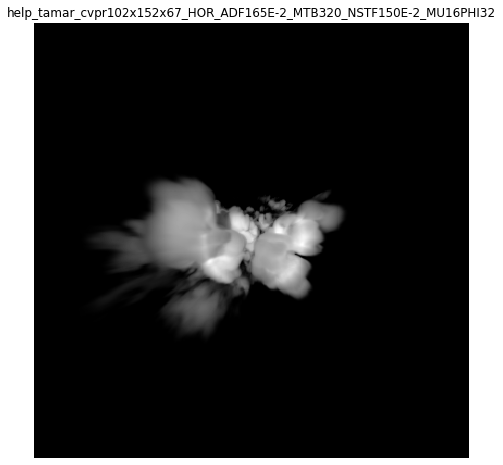

In [4]:

output_dir = '../vadim/experiments/help_tamar_cvpr102x152x67_HOR_ADF200E-2_MTB320_NSTF150E-2_MU32PHI64/monochromatic'
# load the measurments to see the rendered images:
measurements = shdom.load_forward_model_measurements(output_dir)
last_name = this_name
# A Measurements object bundles together the imaging geometry and sensor measurements for later optimization.
USED_CAMERA = measurements.camera
RENCERED_IMAGES = measurements.images
gt_image = RENCERED_IMAGES[0]

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(gt_image,cmap='gray')
ax.invert_xaxis() 
ax.invert_yaxis() 
ax.axis('off')
ax.set_title(last_name)

1.5 1.65 512 14.492776036875794 7420.301330880407 135.3886
1.5 1.1 512 9.659236906703967 4945.529296232431 81.79703333333333
1.5 1.5 512 13.186924376194202 6751.705280611432 139.972
1.1 1.65 512 10.89391210011512 5577.682995258941 122.08525
1.1 1.1 512 7.253677088308765 3713.882669214088 124.19766666666666
1.1 1.5 512 9.893652676499496 5065.550170367742 133.44466666666668
0.92 1.65 512 9.270405822780523 4746.447781263628 113.47798333333334
0.92 1.1 512 6.178672870474852 3163.480509683124 124.74551666666666
0.92 1.5 512 8.42668477817033 4314.462606423209 122.83646666666667
1.5 1.65 128 16.703026438443185 2137.9873841207277 33.38381666666667
1.5 1.1 128 11.097281632335193 1420.4520489389047 19.123949999999997
1.5 1.5 128 15.235041835903251 1950.0853549956162 26.249433333333332
1.1 1.65 128 13.105952044543802 1677.5618617016066 30.669500000000003
1.1 1.1 128 8.709228133533916 1114.7812010923412 30.889116666666666
1.1 1.5 128 11.930412456365472 1527.0927944147804 25.95345
0.92 1.65 128 11.

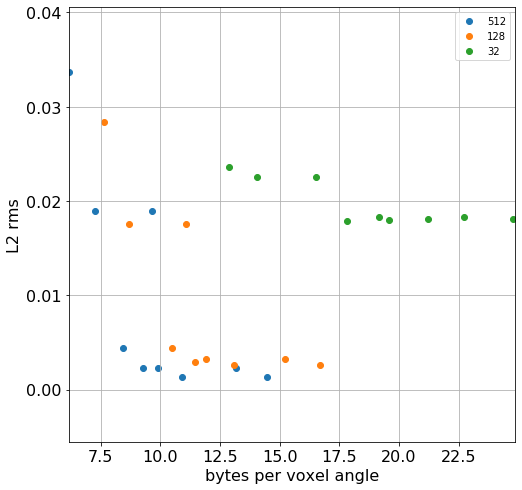

In [6]:
#  show data:
"""
d_data['wantmem'] = g_wantmem/1.048576 # convert to Mbyte
d_data['profile'] = g_rte_solve/1.048576 # convert to Mbyte
d_data['time'] = g_time
d_data['per_voxel'] = d_data['profile']/(fx*fy*fz)
d_data['per_voxel_angle'] = d_data['profile']/((fx*fy*fz)*num_mu*num_phi)
d_data['error']=0
"""
# order: d_nstf, d_agf, d_ANGULAR, d_data.

f, ax = plt.subplots(1, 1, figsize=(8, 8))

for k_angular in ANGULAR_RES:
    
    x = []
    y = []

    for k_nstf in d_nstf.keys():

        d_agf = d_nstf[k_nstf]
        for k_agf in d_agf.keys():
            d_ANGULAR = d_agf[k_agf]


            if(k_angular in d_ANGULAR.keys()):
                
                d_data = d_ANGULAR[k_angular]
#                 if(k_angular == 512):
#                     print(d_data['error'])
                    
                print(k_nstf,k_agf,k_angular,1e6*d_data['per_voxel_angle'],1e6*d_data['per_voxel'],d_data['time']/60)

    #             x.append(1e6*d_data['per_voxel'])
                x.append(1e6*d_data['per_voxel_angle'])
    #             y.append(d_data['time']/60)
                y.append(d_data['error'])
        
    plt.scatter(x, y,label='{}'.format(k_angular))

# plt.yscale('log')    
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
plt.xlabel("bytes per voxel angle", fontsize=16)# sinse x axis is wavelengths*1e3
# plt.xlabel("adaptive grid factor", fontsize=16)# sinse x axis is wavelengths*1e3
# plt.ylabel("time [min]", fontsize=16)
plt.ylabel("L2 rms", fontsize=16)
plt.legend()

plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)

# Changing adaptive grid factor 

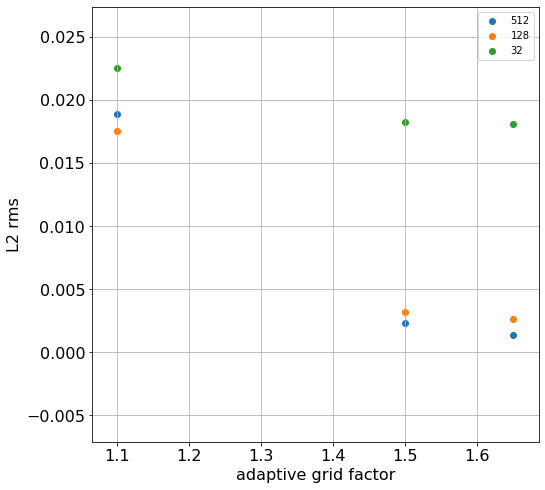

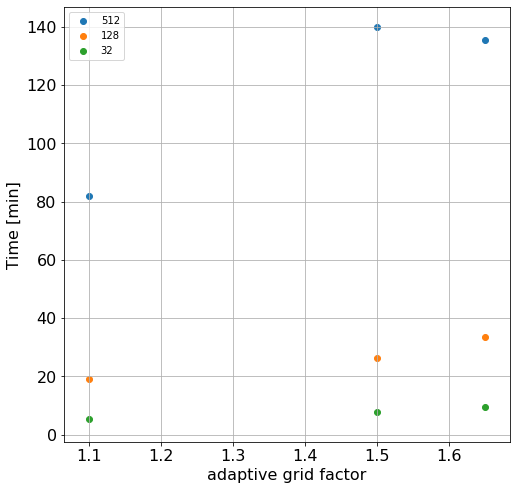

In [32]:
# show data:
"""
d_data['wantmem'] = g_wantmem/1.048576 # convert to Mbyte
d_data['profile'] = g_rte_solve/1.048576 # convert to Mbyte
d_data['time'] = g_time
d_data['per_voxel'] = d_data['profile']/(fx*fy*fz)
d_data['per_voxel_angle'] = d_data['profile']/((fx*fy*fz)*num_mu*num_phi)
d_data['error']=0
"""
# order: d_nstf, d_agf, d_ANGULAR, d_data.

f, ax = plt.subplots(1, 1, figsize=(8, 8))
k_nstf = 1.5

for k_angular in ANGULAR_RES:
    
    x = []
    y = []

    d_agf = d_nstf[k_nstf]
    for k_agf in d_agf.keys():
        d_ANGULAR = d_agf[k_agf]
        if not bool(d_ANGULAR):
            continue
        d_data = d_ANGULAR[k_angular]
        


        x.append(k_agf)
    #             x.append(1e6*d_data['per_voxel_angle'])
    #             y.append(d_data['time']/60)
        y.append(d_data['error'])

    
    plt.scatter(x, y,label='{}'.format(k_angular))
    
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
# plt.xlabel("bytes per voxel", fontsize=16)# sinse x axis is wavelengths*1e3
plt.xlabel("adaptive grid factor", fontsize=16)# sinse x axis is wavelengths*1e3
# plt.ylabel("time [min]", fontsize=16)
plt.ylabel("L2 rms", fontsize=16)
plt.legend()
# plt.yscale('log')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.autoscale(enable=True, axis='y', tight=True)


#--------------------------------------------------------

f, ax = plt.subplots(1, 1, figsize=(8, 8))

for k_angular in ANGULAR_RES:
    
    x = []
    y = []

    d_agf = d_nstf[k_nstf]
    for k_agf in d_agf.keys():
        d_ANGULAR = d_agf[k_agf]
        if not bool(d_ANGULAR):
            continue
        d_data = d_ANGULAR[k_angular]
        


        x.append(k_agf)
    #             x.append(1e6*d_data['per_voxel_angle'])
        y.append(d_data['time']/60)

    
    plt.scatter(x, y,label='{}'.format(k_angular))
    
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
# plt.xlabel("bytes per voxel", fontsize=16)# sinse x axis is wavelengths*1e3
plt.xlabel("adaptive grid factor", fontsize=16)# sinse x axis is wavelengths*1e3
# plt.ylabel("time [min]", fontsize=16)
plt.ylabel("Time [min]", fontsize=16)
plt.legend()
# plt.yscale('log')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.autoscale(enable=True, axis='y', tight=True)

# Changing sh factor

1.5
1.1
0.92
1.5
1.1
0.92
1.5
1.1
0.92
1.5
1.1
0.92
1.5
1.1
0.92
1.5
1.1
0.92


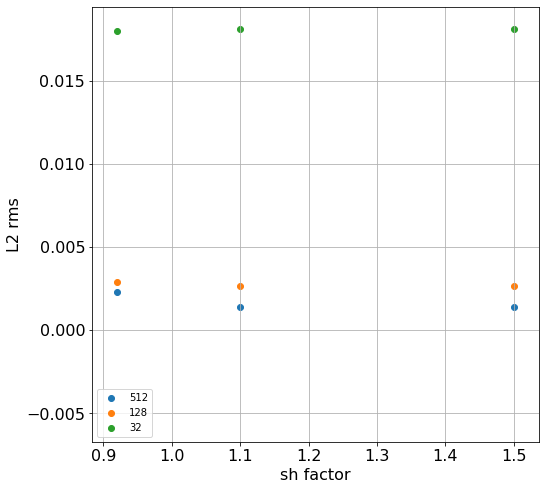

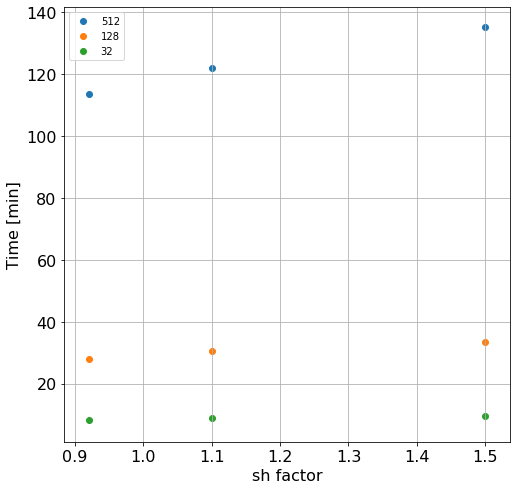

In [33]:
# show data:
"""
d_data['wantmem'] = g_wantmem/1.048576 # convert to Mbyte
d_data['profile'] = g_rte_solve/1.048576 # convert to Mbyte
d_data['time'] = g_time
d_data['per_voxel'] = d_data['profile']/(fx*fy*fz)
d_data['per_voxel_angle'] = d_data['profile']/((fx*fy*fz)*num_mu*num_phi)
d_data['error']=0
"""
# order: d_nstf, d_agf, d_ANGULAR, d_data.

f, ax = plt.subplots(1, 1, figsize=(8, 8))
k_agf = 1.65

for k_angular in ANGULAR_RES:
    
    x = []
    y = []

    
    for k_nstf in d_nstf.keys():
        
        d_agf = d_nstf[k_nstf]
        d_ANGULAR = d_agf[k_agf]
        if not bool(d_ANGULAR):
            continue
        print(k_nstf)
        d_data = d_ANGULAR[k_angular]


        x.append(k_nstf)
    #             x.append(1e6*d_data['per_voxel_angle'])
    #             y.append(d_data['time']/60)
        y.append(d_data['error'])

    
    plt.scatter(x, y,label='{}'.format(k_angular))
    
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
# plt.xlabel("bytes per voxel", fontsize=16)# sinse x axis is wavelengths*1e3
plt.xlabel("sh factor", fontsize=16)# sinse x axis is wavelengths*1e3
# plt.ylabel("time [min]", fontsize=16)
plt.ylabel("L2 rms", fontsize=16)
plt.legend()
# plt.yscale('log')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.autoscale(enable=True, axis='y', tight=True)


# ------time---------------------------------

f, ax = plt.subplots(1, 1, figsize=(8, 8))

for k_angular in ANGULAR_RES:
    
    x = []
    y = []

    
    for k_nstf in d_nstf.keys():
        
        d_agf = d_nstf[k_nstf]
        d_ANGULAR = d_agf[k_agf]
        if not bool(d_ANGULAR):
            continue
        print(k_nstf)
        d_data = d_ANGULAR[k_angular]


        x.append(k_nstf)
    #             x.append(1e6*d_data['per_voxel_angle'])
        y.append(d_data['time']/60)

    
    plt.scatter(x, y,label='{}'.format(k_angular))
    
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
# plt.xlabel("bytes per voxel", fontsize=16)# sinse x axis is wavelengths*1e3
plt.xlabel("sh factor", fontsize=16)# sinse x axis is wavelengths*1e3
# plt.ylabel("time [min]", fontsize=16)
plt.ylabel("Time [min]", fontsize=16)
plt.legend()
# plt.yscale('log')
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.autoscale(enable=True, axis='y', tight=True)

# SHDOM TABLE

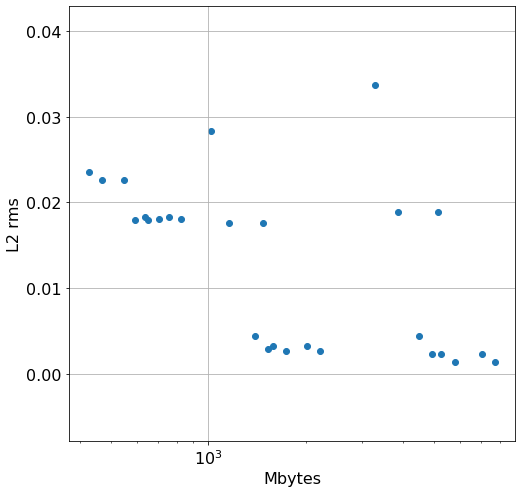

In [34]:
#  show data:
"""
d_data['wantmem'] = g_wantmem/1.048576 # convert to Mbyte
d_data['profile'] = g_rte_solve/1.048576 # convert to Mbyte
d_data['time'] = g_time
d_data['per_voxel'] = d_data['profile']/(fx*fy*fz)
d_data['per_voxel_angle'] = d_data['profile']/((fx*fy*fz)*num_mu*num_phi)
d_data['error']=0
"""
# order: d_nstf, d_agf, d_ANGULAR, d_data.

f, ax = plt.subplots(1, 1, figsize=(8, 8))
x = []
y  = []
z = []

for k_angular in ANGULAR_RES:
    
    for k_nstf in d_nstf.keys():

        d_agf = d_nstf[k_nstf]
        for k_agf in d_agf.keys():
            d_ANGULAR = d_agf[k_agf]


            if(k_angular in d_ANGULAR.keys()):
                
                d_data = d_ANGULAR[k_angular]
#                 if(k_angular == 512):
#                     print(d_data['error'])
                    
#                 print(k_nstf,k_agf,k_angular,1e6*d_data['per_voxel_angle'],1e6*d_data['per_voxel'],d_data['time']/60)

                x.append(d_data['profile'])
                y.append(d_data['error'])
                z.append(d_data['time']/60)
        
plt.scatter(x, y)

# plt.yscale('log')    
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.grid(True)
plt.xlabel("Mbytes", fontsize=16)# sinse x axis is wavelengths*1e3
# plt.xlabel("adaptive grid factor", fontsize=16)# sinse x axis is wavelengths*1e3
# plt.ylabel("time [min]", fontsize=16)
plt.ylabel("L2 rms", fontsize=16)
plt.xscale('log')

COLUMNS = ['Time [min]','Momory [MB]','Error']

shdom_time = np.array(z) # min
total_memory = np.array(x)
error = np.array(y)

# --pandas:
shdom_df = pd.DataFrame(data={'memory':np.array(total_memory),'time':np.array(shdom_time),'error':np.array(error)})
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.autoscale(enable=True, axis='y', tight=True)

# Create Tamars Table

In [15]:
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [29]:
rrDdepth = 200
photons_per_pixel = [16384, 8192, 4096, 1024, 256, 64, 16, 8]
mitsuba_time = [26.1,14.02,7.14, 1.8, 0.39, 0.1, 0.03, 0.016] # min
total_memory = [174.3781888,160.432128,153.4066688,147.6395008,146.276352,145.752064,145.1229184,140.9286144]

error = [0.01314095,0.01315256,0.01265208,0.01391322,0.01713811,0.02576349,0.05451604,0.08688698]
# mitsuba_data_rrd100 = np.vstack((mitsuba_time,total_memory,error))
mitsuba_data_rrd200 = pd.DataFrame(data={'memory':np.array(total_memory),'time':np.array(mitsuba_time),'error':np.array(error)})

# -----------------
rrDdepth = 5
mitsuba_time = [21.17,10.14,5.7,1.2,0.29,0.074,0.02,0.0129] # min
total_memory = [174.3781888,160.5369856,153.1969536,147.849216,145.4374912,145.752064,142.606336,140.9286144]

error = [0.01601763,0.01689619,0.01753552,0.02640902,0.04964125,0.08687902,0.15379944,0.189407066]
# mitsuba_data_rrd5 = np.vstack((mitsuba_time,total_memory,error))
mitsuba_data_rrd5 = pd.DataFrame(data={'memory':np.array(total_memory),'time':np.array(mitsuba_time),'error':np.array(error)})



# Tamars results

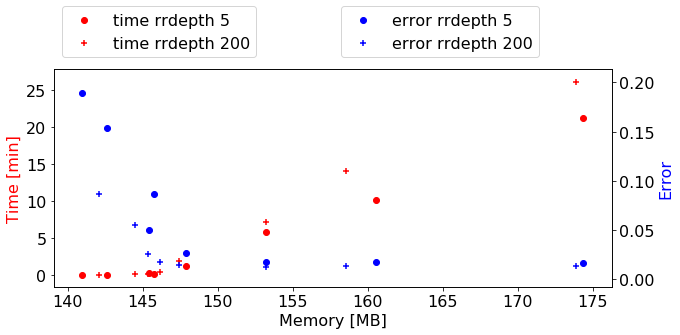

In [30]:
fig,ax = plt.subplots(figsize=(10,4))
M_time_5 = mitsuba_data_rrd5['time']
M_error_5 = mitsuba_data_rrd5['error']
M_memory_5 = mitsuba_data_rrd5['memory']

M_time_200 = mitsuba_data_rrd200['time']
M_error_200 = mitsuba_data_rrd200['error']
M_memory_200 = mitsuba_data_rrd200['memory']

ax.scatter(M_memory_5,M_time_5,marker='o',color='r', label='time rrdepth 5')
ax.scatter(M_memory_100,M_time_200,marker='+',color='r', label='time rrdepth 200')

ax.set_xlabel("Memory [MB]", fontsize=16)
ax.set_ylabel("Time [min]",color="red",fontsize=16)
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.legend(bbox_to_anchor=(0,1.02,0.5,0.2), loc="lower left",prop={'size': 16})

ax2=ax.twinx()
ax2.scatter(M_memory_5, M_error_5,marker='o',color="b",label='error rrdepth 5')
ax2.scatter(M_memory_100, M_error_200,marker='+',color="b",label='error rrdepth 200')
# plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.legend(bbox_to_anchor=(0.5,1.02,1,0.2), loc="lower left",prop={'size': 16})

ax2.set_ylabel("Error",color="blue",fontsize=16)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
# plt.xscale('log')


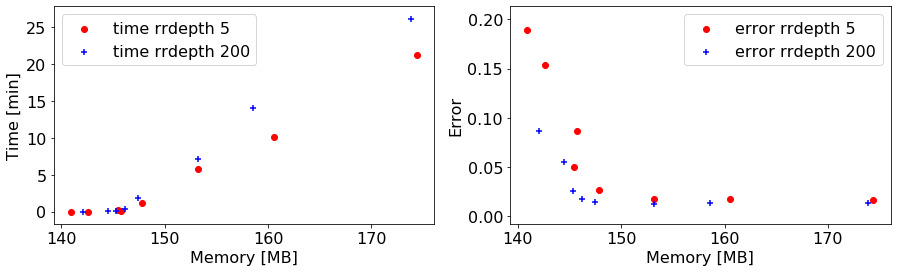

In [58]:
fig,ax = plt.subplots(1,2,figsize=(15,4))
M_time_5 = mitsuba_data_rrd5['time']
M_error_5 = mitsuba_data_rrd5['error']
M_memory_5 = mitsuba_data_rrd5['memory']

M_time_200 = mitsuba_data_rrd200['time']
M_error_200 = mitsuba_data_rrd200['error']
M_memory_200 = mitsuba_data_rrd200['memory']

ax[0].scatter(M_memory_5,M_time_5,marker='o',color='r', label='time rrdepth 5')
ax[0].scatter(M_memory_100,M_time_200,marker='+',color='b', label='time rrdepth 200')

ax[0].set_xlabel("Memory [MB]", fontsize=16)
ax[0].set_ylabel("Time [min]",fontsize=16)
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[0].legend(prop={'size': 16})
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)


ax2=ax[1]
ax2.scatter(M_memory_5, M_error_5,marker='o',color="r",label='error rrdepth 5')
ax2.scatter(M_memory_100, M_error_200,marker='+',color="b",label='error rrdepth 200')
# plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
ax2.legend(prop={'size': 16})
ax2.set_xlabel("Memory [MB]", fontsize=16)
ax2.set_ylabel("Error",fontsize=16)

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)

fig.subplots_adjust(top=0.88)

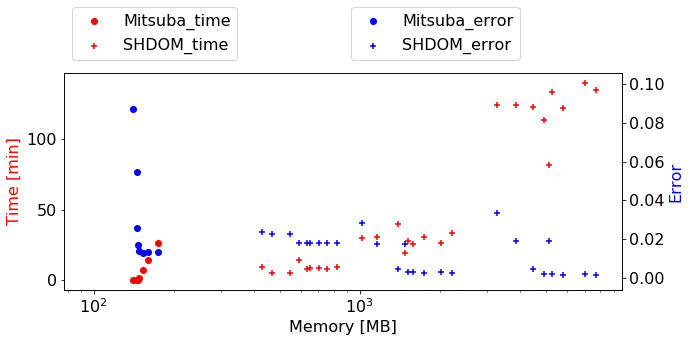

In [31]:
fig,ax = plt.subplots(figsize=(10,4))
M_time_ = mitsuba_data_rrd200['time']
M_error_ = mitsuba_data_rrd200['error']
M_memory_ = mitsuba_data_rrd200['memory']

S_time_ = shdom_df['time']
S_error_ = shdom_df['error']
S_memory_ = shdom_df['memory']

ax.scatter(M_memory_,M_time_,marker='o',color='r', label='Mitsuba_time')
ax.scatter(S_memory_,S_time_,marker='+',color='r', label='SHDOM_time')

ax.set_xlabel("Memory [MB]", fontsize=16)
ax.set_ylabel("Time [min]",color="red",fontsize=16)
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.legend(bbox_to_anchor=(0,1.02,0.5,0.2), loc="lower left",prop={'size': 16})

ax2=ax.twinx()
ax2.scatter(M_memory_, M_error_,marker='o',color="b",label='Mitsuba_error')
ax2.scatter(S_memory_, S_error_,marker='+',color="b",label='SHDOM_error')
# plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.legend(bbox_to_anchor=(0.5,1.02,1,0.2), loc="lower left",prop={'size': 16})

ax2.set_ylabel("Error",color="blue",fontsize=16)

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
plt.xscale('log')



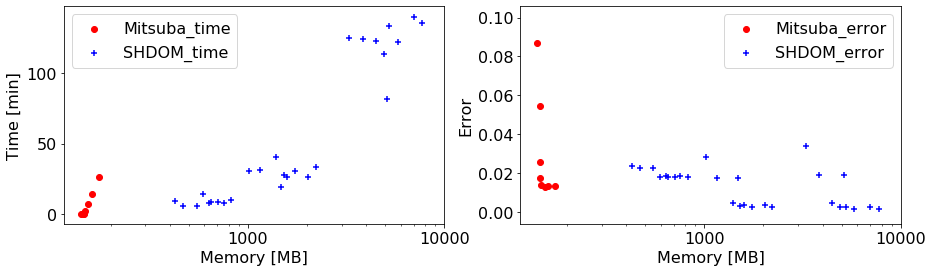

In [56]:
import matplotlib.ticker
fig,ax = plt.subplots(1,2,figsize=(15,4))
M_time_ = mitsuba_data_rrd200['time']
M_error_ = mitsuba_data_rrd200['error']
M_memory_ = mitsuba_data_rrd200['memory']

S_time_ = shdom_df['time']
S_error_ = shdom_df['error']
S_memory_ = shdom_df['memory']

ax[0].scatter(M_memory_,M_time_,marker='o',color='r', label='Mitsuba_time')
ax[0].scatter(S_memory_,S_time_,marker='+',color='b', label='SHDOM_time')

ax[0].set_xlabel("Memory [MB]", fontsize=16)
ax[0].set_ylabel("Time [min]",fontsize=16)
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[0].legend(prop={'size': 16})
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].set_xscale('log')
ax[0].set_xticks([1000,10000])
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax2 = ax[1]
ax2.scatter(M_memory_, M_error_,marker='o',color="r",label='Mitsuba_error')
ax2.scatter(S_memory_, S_error_,marker='+',color="b",label='SHDOM_error')
# plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.legend(prop={'size': 16})

ax2.set_ylabel("Error",fontsize=16)
ax2.set_xlabel("Memory [MB]", fontsize=16)

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.set_xscale('log')
ax2.set_xticks([1000,10000])
ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

fig.subplots_adjust(top=0.88)


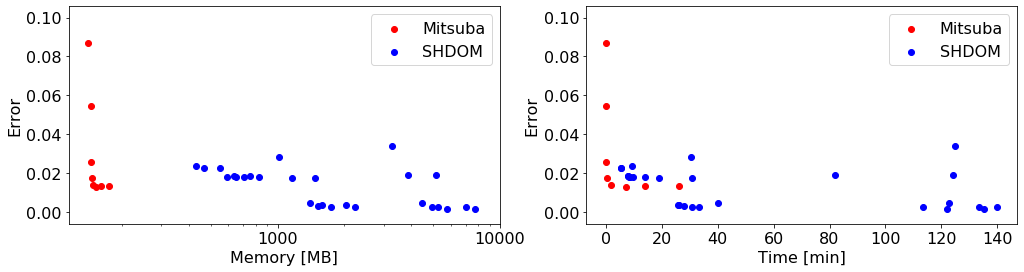

In [63]:
import matplotlib.ticker
fig,ax = plt.subplots(1,2,figsize=(17,4))
M_time_ = mitsuba_data_rrd200['time']
M_error_ = mitsuba_data_rrd200['error']
M_memory_ = mitsuba_data_rrd200['memory']

S_time_ = shdom_df['time']
S_error_ = shdom_df['error']
S_memory_ = shdom_df['memory']

ax[0].scatter(M_memory_,M_error_,marker='o',color='r', label='Mitsuba')
ax[0].scatter(S_memory_,S_error_,marker='o',color='b', label='SHDOM')

ax[0].set_ylabel("Error", fontsize=16)
ax[0].set_xlabel("Memory [MB]",fontsize=16)
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax[0].legend(prop={'size': 16})
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].set_xscale('log')
ax[0].set_xticks([1000,10000])
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax2 = ax[1]
ax2.scatter(M_time_, M_error_,marker='o',color="r",label='Mitsuba')
ax2.scatter(S_time_, S_error_,marker='o',color="b",label='SHDOM')
# plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0)
plt.legend(prop={'size': 16})

ax2.set_ylabel("Error",fontsize=16)
ax2.set_xlabel("Time [min]", fontsize=16)

ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)



fig.subplots_adjust(top=0.88)